This project focuses on learning about Data wrangling,getting a grip about Recommendation System that being a Product Recommendation System. The main objective is to build a Product Recommendation System that recommends atleast 5 new products prioritizing the user's habits.

In [2]:
#Importing the required libraries 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Now let's load the dataset and let's provide it with some columns 

In [17]:
zap_df = pd.read_csv('C:/Users/Hp/Downloads/Electronic_dataset.csv')
zap_df.columns = ['UserId','ProductId','Rating','Timestamp']
zap_df = zap_df.dropna()
zap_df.head()

,UserId,ProductId,Rating,Timestamp
0,A3L1GVWVJKWZZS,B0058UUR6E,5.0,1364774400
1,A08831071BVKZMKNCPI5S,B009ID0VVS,5.0,1357257600
2,A1SINU2I4IOPNU,B000GBO9IM,4.0,1358121600
3,A3P3P31EEOX2BD,B00CDCIOHO,3.0,1404950400
4,A3DBLJ3MPBJQMN,B000MS3VGA,5.0,1294444800


Let's drop the timestamp column 

In [18]:
zap_df.drop('Timestamp',axis=1,inplace=True)

In [19]:
zap_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 0 to 499999
Data columns (total 3 columns):
UserId       500000 non-null object
ProductId    500000 non-null object
Rating       500000 non-null float64
dtypes: float64(1), object(2)
memory usage: 15.3+ MB


Let's eyeball the number of rows and columns 

In [20]:
rows,columns=zap_df.shape
print('Number of rows: ',rows)
print('Number of columns: ',columns)

Number of rows:  500000
Number of columns:  3


Let's do a datatypes check now

In [21]:
zap_df.dtypes

UserId        object
ProductId     object
Rating       float64
dtype: object

In [22]:
zap_df['Rating'].describe().transpose()

count    500000.000000
mean          4.013172
std           1.379996
min           1.000000
25%           3.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: Rating, dtype: float64

# No of users providing minimum rating


In [28]:
print('User who provided minimum number of rating')
zap_df['UserId'][zap_df.Rating == zap_df['Rating'].min()].count()

User who provided minimum number of rating


57452

# No of users providing maximum rating


In [30]:
print('User who provided maximum number of rating')
zap_df['UserId'][zap_df.Rating == zap_df['Rating'].max()].count()

User who provided maximum number of rating


277826

# Showcasing Ratings Frequency

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Rating')]

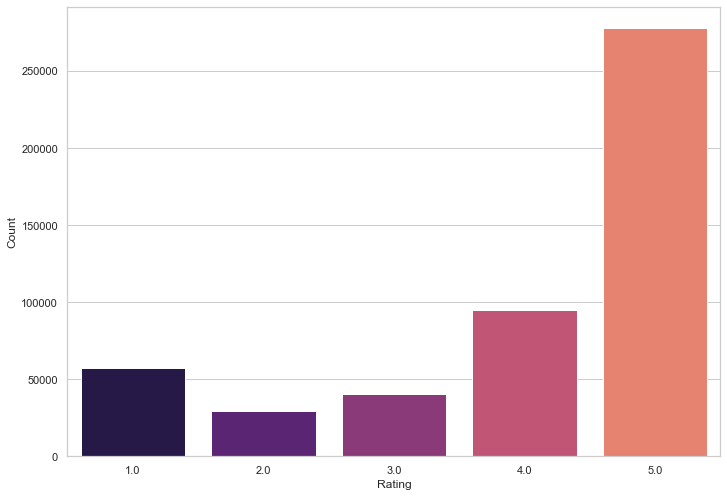

In [31]:
sns.set(rc={'figure.figsize': (11.7, 8.27)})
sns.set_style('whitegrid')
ax = sns.countplot(x='Rating', data=zap_df, palette=sns.color_palette("magma"))
ax.set(xlabel='Rating', ylabel='Count')
plt.show()

Seems like majority of the ratings range from the scale of 4 to 5 and most of them being in the 5.0 area. 

# Taking the subset of the dataset

In [32]:
top=zap_df['UserId'].value_counts()

In [38]:
top50 = top[top>=20]

In [39]:
DFZ= zap_df[zap_df.UserId.isin(top50.index)]

In [40]:
DFZ.head()

,UserId,ProductId,Rating
983,A680RUE1FDO8B,B004URTJ6U,4.0
2726,A6FIAB28IS79,B004J3ZV62,5.0
2740,A6FIAB28IS79,B0012UKOV2,5.0
4741,A2WLNSZ9U0T1S3,B006SVV6HG,3.0
5932,A5JLAU2ARJ0BO,B004RO9L50,2.0


In [41]:
DFZ.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330 entries, 983 to 499182
Data columns (total 3 columns):
UserId       330 non-null object
ProductId    330 non-null object
Rating       330 non-null float64
dtypes: float64(1), object(2)
memory usage: 10.3+ KB


# Calculating the density of the Rating Matrix


In [43]:

rating_matrix = DFZ.pivot(index='UserId',columns = 'ProductId',values='Rating').fillna(0)
print('Shape of final_ratings_matrix: ', rating_matrix.shape)
given_num_of_ratings = np.count_nonzero(rating_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = rating_matrix.shape[0] * rating_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

Shape of final_ratings_matrix:  (13, 326)
given_num_of_ratings =  330
possible_num_of_ratings =  4238
density: 7.79%


In [44]:
rating_matrix.head()

ProductId,B00000J1US,B00004R8VC,B00004S9AK,B00004SA30,B00004SD9Q,B00004SSRC,B00004VVGH,B00004Z4ZB,B00004Z6OK,B00005AC8J,...,B00HJ4GX10,B00I0Z427E,B00I9V8D92,B00IT2N9VS,B00ITI04YM,B00JA4VO9S,B00JGGUBPI,B00K6B7KJM,B00KMRGB7C,B00KYMCJF8
UserId,,,,,,,,,,,,,,,,,,,,,
A1F9Z42CFF9IAY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1ODOGXEYECQQ8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0
A231WM2Z2JL0U3,5.0,5.0,5.0,5.0,5.0,5.0,0.0,3.0,3.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2AY4YUOX2N1BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2NOW4U7W3F7RI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,5.0,0.0,0.0,5.0,0.0,5.0,5.0,5.0


In [45]:
rating_matrix.transpose().head()

UserId,A1F9Z42CFF9IAY,A1ODOGXEYECQQ8,A231WM2Z2JL0U3,A2AY4YUOX2N1BQ,A2NOW4U7W3F7RI,A2WLNSZ9U0T1S3,A3LGT6UZL99IW1,A3OXHLG6DIBRW8,A4WEZJOIZIV4U,A5JLAU2ARJ0BO,A680RUE1FDO8B,A6FIAB28IS79,ADLVFFE4VBT8
ProductId,,,,,,,,,,,,,
B00000J1US,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00004R8VC,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00004S9AK,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00004SA30,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00004SD9Q,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now as we can see our memory usage has gone down from 11.4 MB to 1.1 MB 

# Train-Test Split

In [46]:
train_data, test_data = train_test_split(DFZ, test_size = 0.3, random_state=0)

In [47]:
train_data.head()

,UserId,ProductId,Rating
349305,A3OXHLG6DIBRW8,B000V4TMWC,4.0
29945,A5JLAU2ARJ0BO,B0000APSKB,5.0
490635,A2AY4YUOX2N1BQ,B00212O4IE,4.0
22751,A3OXHLG6DIBRW8,B002EPF6YO,4.0
47375,A2NOW4U7W3F7RI,B001SJVU6K,1.0


In [48]:
print(train_data.shape)
print(test_data.shape)

(231, 3)
(99, 3)


# Popularity Based Recommendation System

In [49]:
train_data.head()

,UserId,ProductId,Rating
349305,A3OXHLG6DIBRW8,B000V4TMWC,4.0
29945,A5JLAU2ARJ0BO,B0000APSKB,5.0
490635,A2AY4YUOX2N1BQ,B00212O4IE,4.0
22751,A3OXHLG6DIBRW8,B002EPF6YO,4.0
47375,A2NOW4U7W3F7RI,B001SJVU6K,1.0


In [52]:
train_data_grouped = train_data.groupby('ProductId').agg({'UserId':'count'}).reset_index()
train_data_grouped.rename(columns={'UserId':'Score'},inplace=True)

In [53]:
train_data_grouped.tail()

,ProductId,Score
224,B00JA4VO9S,1
225,B00JGGUBPI,1
226,B00K6B7KJM,1
227,B00KMRGB7C,1
228,B00KYMCJF8,1


In [54]:
train_data_sort = train_data_grouped.sort_values(['Score', 'ProductId'], ascending = [0,1])

In [56]:
train_data_sort['Rank']= train_data_sort['Score'].rank(ascending=0, method='first')

In [57]:
popularity_recommendations = train_data_sort.head()
popularity_recommendations

,ProductId,Score,Rank
204,B00CD8ADKO,2,1.0
219,B00HHRP11C,2,2.0
0,B00004R8VC,1,3.0
1,B00004S9AK,1,4.0
2,B00004SD9Q,1,5.0


In [65]:
def popularity_recommender(UserId):
    user_recommendations = popularity_recommendations
    user_recommendations['UserId'] = UserId

    col = user_recommendations.columns.tolist()
    col = col[-1:] + col[:-1]
    user_recommendations = user_recommendations[col]
    return user_recommendations

In [66]:
user = [1, 15, 159]
for i in user :
    recomm = popularity_recommender(i)
    print('\nMovies Recommended for the user : {} are \n{}'.format(i,recomm))


Movies Recommended for the user : 1 are 
     UserId   ProductId  Score  Rank
204       1  B00CD8ADKO      2   1.0
219       1  B00HHRP11C      2   2.0
0         1  B00004R8VC      1   3.0
1         1  B00004S9AK      1   4.0
2         1  B00004SD9Q      1   5.0

Movies Recommended for the user : 15 are 
     UserId   ProductId  Score  Rank
204      15  B00CD8ADKO      2   1.0
219      15  B00HHRP11C      2   2.0
0        15  B00004R8VC      1   3.0
1        15  B00004S9AK      1   4.0
2        15  B00004SD9Q      1   5.0

Movies Recommended for the user : 159 are 
     UserId   ProductId  Score  Rank
204     159  B00CD8ADKO      2   1.0
219     159  B00HHRP11C      2   2.0
0       159  B00004R8VC      1   3.0
1       159  B00004S9AK      1   4.0
2       159  B00004SD9Q      1   5.0




The recommendations from Popularity based model for each user is the same five products. This is expected as the model does not consider personal preferences/details of the users.


# Collaborative Filtering Model

In [67]:
# User-based Collaborative Filtering
# Matrix with row per 'user' and column per 'product' 
print('shape for the Matrix : ',rating_matrix.shape)
rating_matrix.head()

shape for the Matrix :  (13, 326)


ProductId,B00000J1US,B00004R8VC,B00004S9AK,B00004SA30,B00004SD9Q,B00004SSRC,B00004VVGH,B00004Z4ZB,B00004Z6OK,B00005AC8J,...,B00HJ4GX10,B00I0Z427E,B00I9V8D92,B00IT2N9VS,B00ITI04YM,B00JA4VO9S,B00JGGUBPI,B00K6B7KJM,B00KMRGB7C,B00KYMCJF8
UserId,,,,,,,,,,,,,,,,,,,,,
A1F9Z42CFF9IAY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1ODOGXEYECQQ8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0
A231WM2Z2JL0U3,5.0,5.0,5.0,5.0,5.0,5.0,0.0,3.0,3.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2AY4YUOX2N1BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2NOW4U7W3F7RI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,5.0,0.0,0.0,5.0,0.0,5.0,5.0,5.0


In [68]:
# add new column user_index to the DF
rating_matrix['user_index']=np.arange(0,rating_matrix.shape[0],1)
print('shape for the Matrix : ',rating_matrix.shape)
rating_matrix.head()

shape for the Matrix :  (13, 327)


ProductId,B00000J1US,B00004R8VC,B00004S9AK,B00004SA30,B00004SD9Q,B00004SSRC,B00004VVGH,B00004Z4ZB,B00004Z6OK,B00005AC8J,...,B00I0Z427E,B00I9V8D92,B00IT2N9VS,B00ITI04YM,B00JA4VO9S,B00JGGUBPI,B00K6B7KJM,B00KMRGB7C,B00KYMCJF8,user_index
UserId,,,,,,,,,,,,,,,,,,,,,
A1F9Z42CFF9IAY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A1ODOGXEYECQQ8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1
A231WM2Z2JL0U3,5.0,5.0,5.0,5.0,5.0,5.0,0.0,3.0,3.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A2AY4YUOX2N1BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A2NOW4U7W3F7RI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,5.0,0.0,0.0,5.0,0.0,5.0,5.0,5.0,4


In [69]:
rating_matrix.set_index(['user_index'],inplace=True)

# SVD 

In [71]:
from scipy.sparse.linalg import svds
# Singular Value Decomposition
U, sigma, Vt = svds(rating_matrix, k = 10)
# Construction of  diagonal array in SVD
sigma = np.diag(sigma)

In [72]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted Ratings
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = rating_matrix.columns)
preds_df.head()

ProductId,B00000J1US,B00004R8VC,B00004S9AK,B00004SA30,B00004SD9Q,B00004SSRC,B00004VVGH,B00004Z4ZB,B00004Z6OK,B00005AC8J,...,B00HJ4GX10,B00I0Z427E,B00I9V8D92,B00IT2N9VS,B00ITI04YM,B00JA4VO9S,B00JGGUBPI,B00K6B7KJM,B00KMRGB7C,B00KYMCJF8
0,3.825383e-01,3.825383e-01,3.825383e-01,3.825383e-01,3.825383e-01,3.825383e-01,2.277466e-15,2.295230e-01,2.295230e-01,3.825383e-01,...,3.166044e-16,6.690058e-16,6.690058e-16,-1.391081e-16,-1.043311e-16,6.690058e-16,6.673390e-16,6.690058e-16,6.690058e-16,6.690058e-16
1,-1.506044e-16,-1.506044e-16,-1.506044e-16,-1.506044e-16,-1.506044e-16,-1.506044e-16,1.166183e-15,-9.036265e-17,-9.036265e-17,-1.506044e-16,...,2.096460e-16,-5.134991e-16,-5.134991e-16,-8.531645e-17,-6.398734e-17,-5.134991e-16,4.000000e+00,-5.134991e-16,-5.134991e-16,-5.134991e-16
2,4.970560e+00,4.970560e+00,4.970560e+00,4.970560e+00,4.970560e+00,4.970560e+00,-6.495400e-17,2.982336e+00,2.982336e+00,4.970560e+00,...,5.410247e-16,-1.749254e-16,-1.749254e-16,3.114534e-16,2.335900e-16,-1.749254e-16,-1.204835e-16,-1.749254e-16,-1.749254e-16,-1.749254e-16
3,-4.316788e-16,-4.316788e-16,-4.316788e-16,-4.316788e-16,-4.316788e-16,-4.316788e-16,-1.258151e-16,-2.590073e-16,-2.590073e-16,-4.316788e-16,...,6.713828e-16,3.954431e-17,3.954431e-17,4.379548e-16,3.284661e-16,3.954431e-17,3.018975e-16,3.954431e-17,3.954431e-17,3.954431e-17
4,-1.749254e-16,-1.749254e-16,-1.749254e-16,-1.749254e-16,-1.749254e-16,-1.749254e-16,-2.660368e-15,-1.049552e-16,-1.049552e-16,-1.749254e-16,...,8.835703e-04,4.999840e+00,4.999840e+00,4.314698e-16,3.236024e-16,4.999840e+00,-4.107993e-16,4.999840e+00,4.999840e+00,4.999840e+00


In [73]:
preds_df.shape

(13, 326)

In [78]:
def recommend_items(userID, pivot_df, preds_df, num_recommendations):
      
    user_idx = userID-1 # index starts at 0
    
    # Get and sort the user's ratings
    sorted_user_ratings = rating_matrix.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [79]:
#Enter 'userID' and 'num_recommendations' for the user #
userID = 12
num_recommendations = 5
recommend_items(userID, rating_matrix, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 12):

                   user_ratings  user_predictions
Recommended Items                                
B00HHRP11C                  0.0      2.787053e-15
B00CD8ADKO                  0.0      2.413779e-15
B00BD7L16G                  0.0      1.866366e-15
B003TNMABW                  0.0      1.866366e-15
B000M4XMGI                  0.0      1.866366e-15


# Evaluating both Models

In [80]:
# Evaluation of Model-based Collaborative Filtering (SVD)
results=pd.DataFrame(index=['RMSE'])
# Actual ratings given by the users
rating_matrix.head()

ProductId,B00000J1US,B00004R8VC,B00004S9AK,B00004SA30,B00004SD9Q,B00004SSRC,B00004VVGH,B00004Z4ZB,B00004Z6OK,B00005AC8J,...,B00HJ4GX10,B00I0Z427E,B00I9V8D92,B00IT2N9VS,B00ITI04YM,B00JA4VO9S,B00JGGUBPI,B00K6B7KJM,B00KMRGB7C,B00KYMCJF8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0
2,5.0,5.0,5.0,5.0,5.0,5.0,0.0,3.0,3.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,5.0,0.0,0.0,5.0,0.0,5.0,5.0,5.0


In [81]:
rating_matrix.mean().head()

ProductId
B00000J1US    0.384615
B00004R8VC    0.384615
B00004S9AK    0.384615
B00004SA30    0.384615
B00004SD9Q    0.384615
dtype: float64

In [82]:
preds_df.mean().head()

ProductId
B00000J1US    0.411777
B00004R8VC    0.411777
B00004S9AK    0.411777
B00004SA30    0.411777
B00004SD9Q    0.411777
dtype: float64

In [83]:
# Preparing a DataFrame for Avg of Actual and Avg of Predicted rating
rmse_df = pd.concat([rating_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(326, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
ProductId,,,
B00000J1US,0.384615,0.411777,0
B00004R8VC,0.384615,0.411777,1
B00004S9AK,0.384615,0.411777,2
B00004SA30,0.384615,0.411777,3
B00004SD9Q,0.384615,0.411777,4


In [84]:
# Calculating the RMSE for the SVD model
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.13244 



In [86]:
results['SVD'] = RMSE

# Time for a Surprise

In [88]:
from surprise.model_selection import train_test_split
from surprise import Reader, Dataset
from surprise import SVD, accuracy
reader = Reader()
data = Dataset.load_from_df(DFZ[['UserId', 'ProductId', 'Rating']], reader)

In [89]:
trainset, testset = train_test_split(data, test_size=0.30)

# KNN User Based Collaborative Filtering 

In [90]:
from surprise import KNNWithMeans
algo = KNNWithMeans(k=25, sim_options={'name': 'cosine', 'user_based': True})
algo.fit(trainset)
test_pred = algo.test(testset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


# RMSE

In [91]:

print("User-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)
print("User-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

User-based Model : Test Set
RMSE: 0.9592


0.9591749013840295

User-based Model : Test Set
RMSE: 0.9592


0.9591749013840295

In [92]:
results['KNN User-User - CF'] = accuracy.rmse(test_pred, verbose=True)

RMSE: 0.9592


In [93]:
print("Results Both The Models: \n",results)

Results Both The Models: 
           SVD  KNN User-User - CF
RMSE  0.13244            0.959175


# Top - K ( K = 5) Recommendations

In [101]:
# Enter 'UserId' and 'num_recommendations' for the user #
UserId = [1,5,10]
num_recommendations = 5
recommend_items(UserId[0], rating_matrix, preds_df, num_recommendations)
recommend_items(UserId[1], rating_matrix, preds_df, num_recommendations)
recommend_items(UserId[2], rating_matrix, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 1):

                   user_ratings  user_predictions
Recommended Items                                
B00000J1US                  0.0          0.382538
B00005AC8J                  0.0          0.382538
B000066JQU                  0.0          0.382538
B00006LHEE                  0.0          0.382538
B00006SG3W                  0.0          0.382538

Below are the recommended items for user(user_id = 5):

                   user_ratings  user_predictions
Recommended Items                                
B001XURP7W                  0.0          0.000884
B00BTJIJ40                  0.0          0.000884
B0014Z29OU                  0.0          0.000884
B0049MOJ2U                  0.0          0.000884
B000VMU9VC                  0.0          0.000884

Below are the recommended items for user(user_id = 10):

                   user_ratings  user_predictions
Recommended Items                                
B0012UKOV2                  

Model-based Collaborative Filtering is a customized recommender framework, the proposals depend on the past conduct of the user and it isn't subject to any extra data. 

The Popularity-based recommender framework is non-customized and the suggestions depend on frequecy checks, which might be not reasonable to the user.
One can see the differance above for the User id 1 ,5 and 10. 
The Popularity based model has suggested similar arrangement of 5 items to both however Collaborative Filtering based model has suggested whole extraordinary rundown dependent on the user's past purchase history